## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction
This is a dataset from an e-commerce website. The company has developed a new web page in order to try and increase the number of users who convert, meaning the number of users who decide to pay for the company's product. The following analysis is to help the company understand if they should implement this new page or keep the old page.

<a id='probability'></a>
#### Part I - Probability

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [3]:
#read the csv file
df = pd.read_csv("ab_data.csv")

#show the data
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [4]:
#number of rows of the dataframe
df.shape

(294478, 5)

In [5]:
#number of unique users
df.user_id.nunique()

290584

In [6]:
#the proportion of users converted
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

In [7]:
#The number of times the `new_page` and `treatment` don't match.
df.query('landing_page == "old_page" & group == "treatment"').count() + \
df.query('landing_page == "old_page" & group == "treatment"').count()

user_id         3930
timestamp       3930
group           3930
landing_page    3930
converted       3930
dtype: int64

In [8]:
#check missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
#Drop mismatch rows
df2 = df.drop(df.query('(landing_page == "old_page" & group == "treatment") | (landing_page == "new_page" & group == "control")').index)

In [10]:
# Double Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
#number of unique user in df2
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [12]:
#check the duplicated user
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

In [13]:
#row information of the user
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
#remove one row of the duplicated value since the result of conversion is the same
df2.drop(labels = 1899,inplace=True)

In [15]:
#probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

In [16]:
#the probability of converted in control group
df2.query('group == "control"').converted.mean()

0.1203863045004612

In [17]:
#the probability of converted in treatment group
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

In [18]:
#the probability that an individual received the new page
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

<h3>Data Exploration Conclusion</h3>

The old page conversion rate is 0.1204 and the new page is 0.1188. We can see that the old page is performing better than the new page. Also the chance of receiving new page is 50% which is quite a significant sample. But we have to perform an A/B test to show that whether we lack the statistical evidence that new page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

We will perform A/B Test to see if we have the statisticaly evidence to support the result. And the below are the null hypothesis $H_{0}$ and alternative hypothesis $H_{1}$. Null hypothesis is that the old page has the same or more conversion rate than the new page and the alternative hypothesis is the new page has more conversion rate than the old page.

<p style="text-align: center;">$H_0: P_{old} >= P_{new}$<br>
$H_1: P_{old} < P_{new}$</p>

In [19]:
#the conversion rate for new page under the null
df2.converted.mean()

0.11959708724499628

In [20]:
#the conversion rate for old page under the null
df2.converted.mean()

0.11959708724499628

In [21]:
#number of individuals in treatment group
df2.query('group == "treatment"').user_id.nunique()

145310

In [22]:
#number of individuals in control group
df2.query('group == "control"').user_id.nunique()

145274

In [23]:
#dataframe of converted individual in treatment group
new_page_converted = df2.query('group == "treatment"').converted

In [24]:
#dataframe of converted individual in control group
old_page_converted = df2.query('group == "control"').converted

In [25]:
#difference in observed value
obs_value = new_page_converted.mean() - old_page_converted.mean()

In [26]:
#bootstrapping from the df2
p_diff = []
for _ in range(10000):
    boot = df2.sample(df.shape[0], replace=True)
    new_page_conver = boot.query('group == "treatment"').converted.mean()
    old_page_conver = boot.query('group == "control"').converted.mean()
    p_diff.append(new_page_conver - old_page_conver)

In [27]:
p_diff = np.array(p_diff)

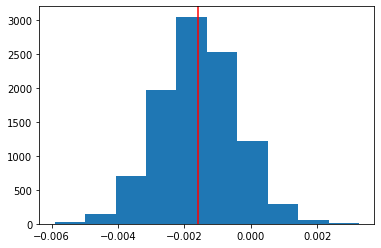

In [28]:
#Hitogram of the bootstrapping result. Red line is where the observed value falls.
plt.hist(p_diff)
plt.axvline(obs_value, color="r")

In [29]:
#p-value for the new page
(p_diff > obs_value).mean()

0.4944

<h3>Conclusion of Boostrapping Result</h3>

The p-value for the hypothesis testing is 0.5054 which is greater than $\alpha$ 0.05. It means that we fail to reject the null hypothesis $H_0$. There is no statistical evidence that $P_{new}$ is different from $P_{old}$.

<h3>Proportions Z-test Approach</h3>

In [30]:
from statsmodels.stats.proportion import proportions_ztest
#prepare values for the proportions Z-test
convert_old = df2.query('group == "control" & converted == 1').shape[0]
convert_new = df2.query('group == "treatment" & converted == 1').shape[0]
n_old = df2.query('group == "control"').user_id.nunique()
n_new = df2.query('group == "treatment"').user_id.nunique()

In [31]:
#perform proportions Z-test
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
stat, pval = proportions_ztest(count, nobs, alternative="smaller")

In [32]:
#Z-score and p-value
stat, pval

(1.3109241984234394, 0.9050583127590245)

<h3>Proportions Z-test Approach Conclusion</h3>

The z-score showing that the new page is 1.311 standard deviation above the mean. But we do not have the statistical evidence to reject the null hypothesis $H_{0}$ since the p-value is 0.9051 which agrees with the findings earlier.

<a id='regression'></a>
### Part III - A regression approach

In [33]:
#import the library
import statsmodels.api as sm
#get the dummy variables
df2[['new_page','old_page']] = pd.get_dummies(df['landing_page'])
df2['intercept'] = 1

In [34]:
#Instantiate regression model
lm = sm.Logit(df2['converted'], df2[['new_page','intercept']])
result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-03-30 01:40 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
new_page     -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
==================================================================

"""

In [35]:
#exponentiate the params to interpret the result
np.exp(result.params)

new_page     0.985123
intercept    0.136863
dtype: float64

In [36]:
1/0.985123

1.0151016675075093

According to the model, old page has 1.015 times higher than the new page. And the p-value is 0.1899.

The p-value is 0.1899 meaning that we failed to reject the null hypothesis. We have no statistical evidence showing $P_{new}$ is different than $P_{old}$. And it is different than the value from Part II since it is a two tailed test instead of a one tailed test.

Putting other related factors in a model can help us better predict and explain more about the result. However, adding variables that are correlated to other explantory variables can make the original relationship disappear. The way to avoid this is to check the Variance Inflation Factor (VIF) or simply plot charts to see the correlation between variables and remove those less important variables.

<h3>Adding other variables</h3>

In [37]:
#read countries csv file
df_con = pd.read_csv('countries.csv')
df_con.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
#join two tables based on user_id
df_combine = df2.merge(df_con, on='user_id', how='left')

In [39]:
#get dummy variables
df_combine[['CA','UK','US']] = pd.get_dummies(df_combine['country'])

In [40]:
#perform logistic regression base on countries
lm = sm.Logit(df_combine['converted'], df_combine[['UK','US','intercept']])
result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-03-30 01:40 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
==================================================================

"""

The p-value for UK (0.07) and US (0.1291) is larger than 0.05 meaning that we do not have the statistical evidence that conversion rate of UK and US is different than CA (our baseline). And for UK and US, their convidence interval overlaps with each other at a significant amount. This means UK show no statistical evidence that conversion rate is different than US.

<h3>Interaction of variables</h3>

In [41]:
lm = sm.Logit(df_combine['converted'], df_combine[['UK','US','new_page','intercept']])
result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-03-30 01:40 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
new_page      -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
==================================================================

"""

The p-value for UK and US is larger than 0.05 $\alpha$ meaning that we do not have the statistical evidence that conversion rate of UK and US is different than CA. And for UK and US, their convidence interval overlaps with each other at a significant amount. This means UK show no statistical evidence that conversion rate is different than US. And the p-value for new page is 0.1912 which is larger than 0.05 $\alpha$. It means we have no statistical evidence to reject the null hypothesis that $P_{new}$ <= $P_{old}$. We can therefore see that adding new variables here does not change the result that we did eariler when we only have individual variable instead of multiple variables.

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0